In [22]:
import pandas as pd
import numpy as np
import torch
from torch import nn
#from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
import re
from tqdm.notebook import tqdm
from datasets import DatasetDict, Dataset
import datasets
import evaluate
import os

In [4]:
tokenizer = BertTokenizerFast.from_pretrained("Rostlab/prot_bert", do_lower_case=False, use_fast=True)
model = BertForSequenceClassification.from_pretrained("Rostlab/prot_bert", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
sequence_Example = "A E T C Z AO"
sequence_Example = re.sub(r"[UZOB]", "X", sequence_Example)
encoded_input = tokenizer(sequence_Example, return_tensors='pt')
output = model(**encoded_input)
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0149, -0.0370]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

# Download and process Bernett's Dataset v4 (added Q96PU5)

Download the old v3 version, that is likely the one that ProtBERT-Gru-Attention used.

Training: Intra1, validation: intra0, test intra2

Each txt file has the protein ID pairs from the human proteome. The corresponding sequences are in the fasta file. It probably is better to pair the sequences and tokenize them before training.

In [5]:
train_pos = pd.read_csv("bernett/FT/Intra1_pos_rr.txt", sep=" ", header=None)
train_neg = pd.read_csv("bernett/FT/Intra1_neg_rr.txt", sep=" ", header=None)
val_pos = pd.read_csv("bernett/FT/Intra0_pos_rr.txt", sep=" ", header=None)
val_neg = pd.read_csv("bernett/FT/Intra0_neg_rr.txt", sep=" ", header=None)
test_pos = pd.read_csv("bernett/FT/Intra2_pos_rr.txt", sep=" ", header=None)
test_neg = pd.read_csv("bernett/FT/Intra2_neg_rr.txt", sep=" ", header=None)

print(f"Train size: {train_pos.shape[0]} positives, {train_neg.shape[0]} negatives, {train_pos.shape[0] + train_neg.shape[0]} total.")
print(f"Validation size: {val_pos.shape[0]} positives, {val_neg.shape[0]} negatives, {val_pos.shape[0] + val_neg.shape[0]} total.")
print(f"Test size: {test_pos.shape[0]} positives, {test_neg.shape[0]} negatives, {test_pos.shape[0] + test_neg.shape[0]} total.")

Train size: 73436 positives, 73436 negatives, 146872 total.
Validation size: 26667 positives, 26667 negatives, 53334 total.
Test size: 23422 positives, 23422 negatives, 46844 total.


Check for NaNs, correct shapes, etc

In [6]:
# Check shape and NaN values
dfs = [train_pos, train_neg, val_pos, val_neg, test_pos, test_neg]
results = {
    "shape_check": [df.shape[1] == 2 for df in dfs],
    "nan_check": [df.isna().sum().sum() == 0 for df in dfs]
}
results = pd.DataFrame(results, index=["train_pos", "train_neg", "val_pos", "val_neg", "test_pos", "test_neg"])
results

,shape_check,nan_check
train_pos,True,True
train_neg,True,True
val_pos,True,True
val_neg,True,True
test_pos,True,True
test_neg,True,True


Map to sequences and add the label:

In [7]:
from Bio import SeqIO

# Load your FASTA file and create a mapping of ID -> Sequence
seq_dict = {record.id: str(record.seq) for record in SeqIO.parse("bernett/human_swissprot_oneliner.fasta", "fasta")}

In [8]:
type(seq_dict)

dict

In [9]:
mapped_dfs = []
for i, df in enumerate(dfs):
  df = df.applymap(lambda id: seq_dict.get(id, np.nan))
  df.columns = ['seq1', 'seq2']
  df['label'] = (i+1) % 2
  mapped_dfs.append(df)

Now, we check if there is any nan sequences, since if there are, then they weren't in the fasta file:

In [10]:
results = {
    "shape_check": [df.shape[1] == 3 for df in mapped_dfs],
    "nan_check": [df.isna().sum().sum() for df in mapped_dfs]
}
results = pd.DataFrame(results, index=["train_pos", "train_neg", "val_pos", "val_neg", "test_pos", "test_neg"])
results

,shape_check,nan_check
train_pos,True,0
train_neg,True,0
val_pos,True,0
val_neg,True,0
test_pos,True,0
test_neg,True,0


In [11]:
mapped_dfs[0].head()

,seq1,seq2,label
0,MRLTLLCCTWREERMGEEGSELPVCASCGQRIYDGQYLQALNADWH...,MAYSQGGGKKKVCYYYDGDIGNYYYGQGHPMKPHRIRMTHNLLLNY...,1
1,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVT...,MVEEVQKHSVHTLVFRSLKRTHDMFVADNGKPVPLDEESHKRKMAI...,1
2,MPVRGDRGFPPRRELSGWLRAPGMEELIWEQYTVTLQKDSKRGFGI...,MKKQFNRMKQLANQTVGRAEKTEVLSEDLLQIERRLDTVRSICHHS...,1
3,MSKAHPPELKKFMDKKLSLKLNGGRHVQGILRGFDPFMNLVIDECV...,MAAMAVGGAGGSRVSSGRDLNCVPEIADTLGAVAKQGFDFLCMPVF...,1
4,MPGPTPSGTNVGSSGRSPSKAVAARAAGSTVRQRKNASCGTRSAGR...,MADPEVCCFITKILCAHGGRMALDALLQEIALSEPQLCEVLQVAGP...,1


Now there aren't any missing sequences!!

Finally, convert them to huggingface datasets:

In [12]:
dataset = DatasetDict({
  "train": Dataset.from_pandas(pd.concat([mapped_dfs[0], mapped_dfs[1]]).reset_index(drop=True)),
  "validation": Dataset.from_pandas(pd.concat([mapped_dfs[2], mapped_dfs[3]]).reset_index(drop=True)),
  "test": Dataset.from_pandas(pd.concat([mapped_dfs[4], mapped_dfs[5]]).reset_index(drop=True))
})
dataset

DatasetDict({
    train: Dataset({
        features: ['seq1', 'seq2', 'label'],
        num_rows: 146872
    })
    validation: Dataset({
        features: ['seq1', 'seq2', 'label'],
        num_rows: 53334
    })
    test: Dataset({
        features: ['seq1', 'seq2', 'label'],
        num_rows: 46844
    })
})

In [13]:
# Free some memory
del mapped_dfs, dfs, results, seq_dict, train_pos, train_neg, val_pos, val_neg, test_pos, test_neg

# Tokenizing

In [14]:
# from concurrent.futures import ProcessPoolExecutor
import math
from functools import partial

def tokenize(batch, tokenizer, N=500):
  seqs1, seqs2 = batch['seq1'], batch['seq2'] # batch must be a dataframe with two columns.

  # replace unknown aminoacids and turn to uppercase
  seqs1 = [re.sub(r"[UZOB]", "X", seq.upper()) for seq in seqs1]
  seqs2 = [re.sub(r"[UZOB]", "X", seq.upper()) for seq in seqs2]

  # Truncate sequences according to the paper
  seqs1 = [seq[:math.ceil(N/2)] + seq[-N//2:] if len(seq) > N else seq for seq in seqs1]
  seqs2 = [seq[:math.ceil(N/2)] + seq[-N//2:] if len(seq) > N else seq for seq in seqs2]

  # introduce spaces between sequences and pad those that are not at least 500
  seqs1 = [' '.join(seq) + f" {tokenizer.pad_token}"*(N - len(seq)) for seq in seqs1]
  seqs2 = [' '.join(seq) + f" {tokenizer.pad_token}"*(N - len(seq)) for seq in seqs2]

  return tokenizer(seqs1, seqs2, padding=False, truncation=False)

tokenize_batch = partial(tokenize, tokenizer=tokenizer, N=500)

In [15]:
tok_dataset = dataset.map(tokenize_batch, num_proc=1, batched=True, batch_size=32)

Map:   0%|          | 0/146872 [00:00<?, ? examples/s]

Map:   0%|          | 0/53334 [00:00<?, ? examples/s]

Map:   0%|          | 0/46844 [00:00<?, ? examples/s]

In [16]:
tok_dataset['train'] = tok_dataset['train'].shuffle(seed=42)

In [17]:
tok_dataset['train']['label'][:10]

[0, 1, 0, 0, 0, 0, 1, 1, 0, 0]

# Fine-tune on PPI

The original paper says that they finetuned ProtBERT using 90% of each dataset. I assume the fine tuning task was to classify PPIs. I also assume that they left out of the training, the validation and test fractions.

In [18]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # convert the logits to their predicted class
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [19]:
model.requires_grad_(False)
model.bert.pooler.requires_grad_(True)
model.classifier.requires_grad_(True)
model.bert.encoder.layer[-1].requires_grad_(True)

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=1024, out_features=1024, bias=True)
      (key): Linear(in_features=1024, out_features=1024, bias=True)
      (value): Linear(in_features=1024, out_features=1024, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=1024, out_features=1024, bias=True)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=1024, out_features=4096, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=4096, out_features=1024, bias=True)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

In [19]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

13647874

In [ ]:
training_args = TrainingArguments(
    output_dir="ProtBERT_FT-PPI",
    #eval_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none",
    logging_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tok_dataset['train'],
    eval_dataset=tok_dataset['validation'],
    compute_metrics=compute_metrics,
    #tokenizer=tokenizer, #Not sure if it will pad the sequences unnecesarily
)
trainer.train()

Epoch,Training Loss,Validation Loss


# Review training and validation accuracies

In [30]:
# Get all checkpoint directories
checkpoint_dir = "ProtBERT_FT-PPI"
checkpoints = sorted(
    [os.path.join(checkpoint_dir, d) for d in os.listdir(checkpoint_dir) if d.startswith("checkpoint")]
)

results = []

for ckpt in checkpoints:
    print(f"Evaluating checkpoint: {ckpt}")

    model = BertForSequenceClassification.from_pretrained(ckpt)

    training_args = TrainingArguments(
        output_dir=ckpt,  # doesn't matter for eval
        per_device_eval_batch_size=64,
        report_to="none",
        do_train=False,
        do_eval=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tok_dataset['train'],
        eval_dataset=tok_dataset['validation'],
        compute_metrics=compute_metrics
    )

    #train_metrics = trainer.evaluate(eval_dataset=tok_dataset['train'])
    val_metrics = trainer.evaluate(eval_dataset=tok_dataset['validation'])

    results.append({
        "checkpoint": os.path.basename(ckpt),
     #   "train_accuracy": train_metrics["eval_accuracy"],
        "val_accuracy": val_metrics["eval_accuracy"],
     #   "train_loss": train_metrics["eval_loss"],
        "val_loss": val_metrics["eval_loss"]
    })

# Convert to DataFrame
df = pd.DataFrame(results)
print(df)

df.to_csv("ProtBERT_FT-PPI_evaluation.csv", sep=" ", header=True, index=False)


Evaluating checkpoint: ProtBERT_FT-PPI/checkpoint-2295


Evaluating checkpoint: ProtBERT_FT-PPI/checkpoint-4590


Evaluating checkpoint: ProtBERT_FT-PPI/checkpoint-6885


        checkpoint  val_accuracy  val_loss
0  checkpoint-2295      0.547231  0.689027
1  checkpoint-4590      0.544868  0.691154
2  checkpoint-6885      0.541924  0.693746


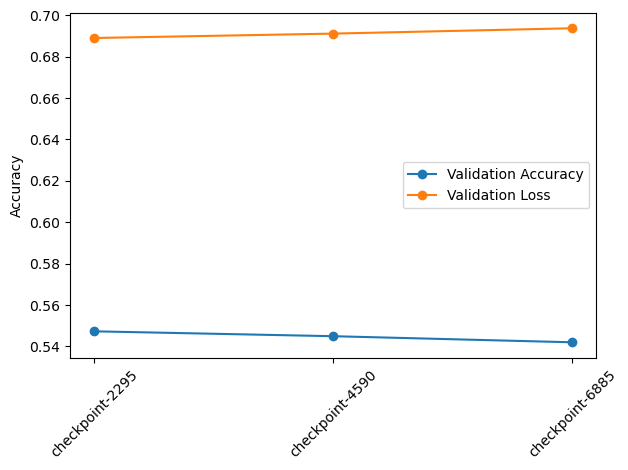

In [34]:
import matplotlib.pyplot as plt

plt.plot(df["checkpoint"], df["val_accuracy"], label="Validation Accuracy", marker='o')
plt.plot(df["checkpoint"], df["val_loss"], label="Validation Loss", marker='o')
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("ProtBERT_FT-PPI_evaluation.png")